In [1]:
#%matplotlib notebook
import time, winsound, h5py
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import beam1d as beam, optics1d as optics, beamline1d as beamline

### Beam parameters

In [2]:
# number of sampling points
N = 2048
# photon energy in eV
E0 = 17795

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 630
}

### Propagate central energy only (no time component) to tune lens roc

In [212]:
def define_devices(
    f1, f2, slit_width = 500e-6, alphaAsym = np.deg2rad(27.98), E0=E0, f0 = 290.):
    # crystal reflection hkl index
    hkl = [6,6,0]

    # viewing point upstream of monochromator
    crl0 = optics.CRL('crl0', z=920, E0=E0, f=f0, diameter=2e-3)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                              alphaAsym=0, orientation=0, pol='s')

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2, E0=E0,
                              alphaAsym=alphaAsym, orientation=2,pol='s')
    
    # viewing point downstream of crystal 2
    im0 = optics.PPM('after_c2', z=crystal2.z+.1,N=256,FOV=2e-3)
    
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    # CRL with ~1 meter focal length (modeled as single element for now)
    crl1 = optics.CRL('crl1', z=crystal2.z+f1, E0=E0, f=f2, diameter=5e-3)

    # slit at focus
    slit = optics.Slit('slit', z=crl1.z+f2, x_width=slit_width, y_width=2e-3)

    # viewing point at focus
    focus = optics.PPM('focus', z=crl1.z+f2 + 1e-3, FOV=100e-6, N=256)

    # second CRL with ~1 meter focal length, for collimation
    crl2 = optics.CRL('crl2', z=crl1.z+2*f2, E0=E0, f=f2, diameter=5e-3)
    
    # viewing point downstream of second crl
    im1 = optics.PPM('after_crl2', z=crl2.z+.1,N=256,FOV=2e-3)
    
    # viewing before crystal 3
    im2_0 = optics.PPM('before_c3', z=crl2.z+f1-.1,N=256,FOV=2e-3)
    
    # third crystal, asymmetric reflection, same orientation as crystal1
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z + f1, E0=E0,
                              alphaAsym=-alphaAsym, asym_type='emergence', orientation=2, pol='s')
    
    # viewing after crystal 3
    im2 = optics.PPM('after_c3', z=crystal3.z+.1,N=256,FOV=2e-3)

    # fourth crystal, symmetric reflection, same orientation as crystal2
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crystal3.z+.2, E0=E0,
                              alphaAsym=0, asym_type='emergence', orientation=0, pol='s')

    # viewing point just downstream of monochromator
    im3 = optics.PPM('output', z=crystal4.z+.1, FOV=2e-3, N=256)

    # list of devices to propagate through
    devices = [crl0,crystal1,crystal2, im0, crl1, slit, focus, crl2, im1, im2_0, crystal3, im2, crystal4, im3]

    return devices

### Propagate energy components and plot beam profiles


In [221]:
%%capture capt
tstart = time.time()
# initialize optical elements
f1 = 9.750953177257525
f2 = 10.

devices = define_devices(f1, f2)

# initialize beamline
mono_beamline = beamline.Beamline(devices)
# propagate
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=400, time_window=10000)
pulse.propagate(beamline=mono_beamline, screen_names=['after_c2', 'focus','after_crl2','before_c3','after_c3','output'])
tfin = time.time()

total 7.11s, per slice 126.9ms


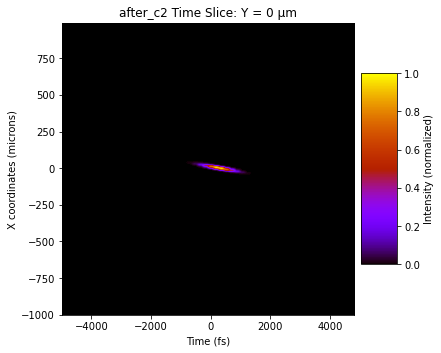

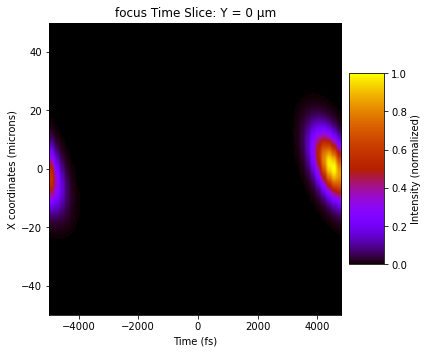

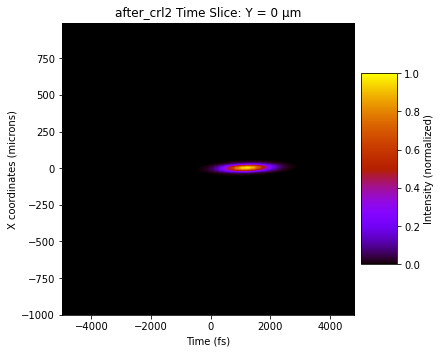

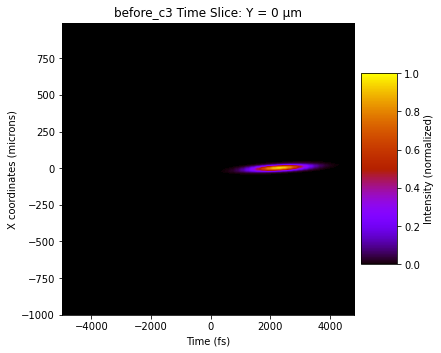

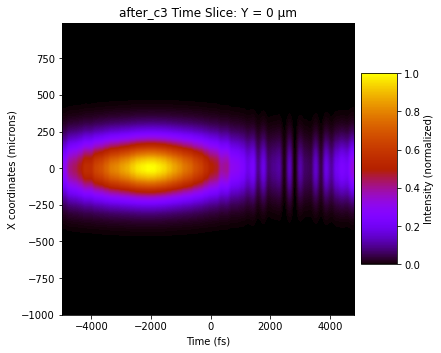

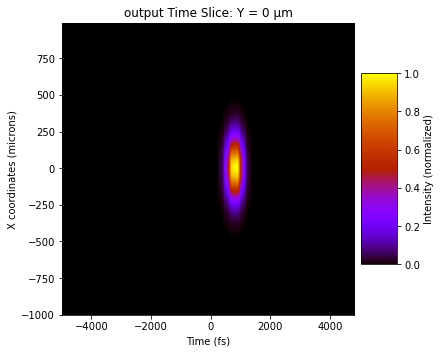

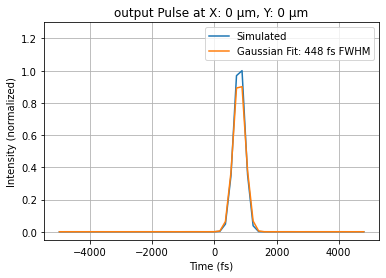

In [222]:
''' time slice '''
print('total {}s, per slice {}ms'.format(round(tfin-tstart,2), round(1000*(tfin-tstart)/pulse.N,2)))

shift = 0
pulse.imshow_time_slice('after_c2', shift = shift)
pulse.imshow_time_slice('focus',shift= shift)
pulse.imshow_time_slice('after_crl2', shift = shift)
pulse.imshow_time_slice('before_c3', shift = shift)
pulse.imshow_time_slice('after_c3', shift = shift)
pulse.imshow_time_slice('output', shift = shift)
pulse.plot_pulse('output', shift = shift)

for i in range(2):
    winsound.Beep(1000,1000)

### Optimization

In [229]:
%%capture capt
tstart = time.time()
NN = 300
f1 = np.linspace(9.745, 9.755, NN)

duration = np.zeros(NN)

for i, f in enumerate(f1):
    devices = define_devices(f, 10)
    # initialize beamline
    mono_beamline = beamline.Beamline(devices)
    # reset central photon energy
    beam_params['photonEnergy'] = E0

    # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
    pulse = beam.Pulse(beam_params=beam_params, tau=400, time_window=20000)

    print('Number of spectral components: {:d}'.format(pulse.N))
    pulse.propagate(beamline=mono_beamline, screen_names=['output'])
    centroid, duration[i] = pulse.pulse_duration('output')
tfin = time.time()


In [230]:
fig_path = "C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots_flip34/"
hkl = devices[2].hkl
hkl = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'pulse_duration_{}_{}keV'.format(
    hkl, round(beam_params['photonEnergy']/1000.,4))

with h5py.File(fig_path+fname+'.h5','w') as f:
    f.create_dataset('f1', data=f1)
    f.create_dataset('duration', data=duration)

9.750953177257525


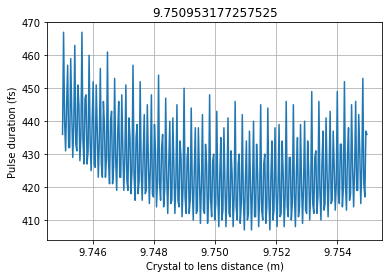

In [231]:
# plot range
f1_min = f1.min()
f1_max = f1.max()
ii = np.argwhere(f1>=f1_min).min()
ifin = np.argwhere(f1<=f1_max).max()

plt.figure()
plt.plot(f1[ii:ifin], np.abs(duration[ii:ifin]))
plt.xlabel('Crystal to lens distance (m)')
plt.ylabel('Pulse duration (fs)')
# plt.ylim(0,200)
plt.grid()
f1_opt = f1[ii:ifin][np.argmin(duration[ii:ifin])]
plt.title(f1_opt)
plt.savefig(fig_path+fname+'_{}-{}m.png'.format(round(f1_min,2), round(f1_max,2)))

print(f1_opt)

In [232]:
for i in range(2):
    winsound.Beep(300,1000)